In [ ]:
%pip install openpyxl

In [ ]:
%pip install statsmodels

In [ ]:
%pip install pmdarima

In [258]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

In [273]:
data = pd.read_excel("dummy_vehicle_sales_data.xlsx")
sales_data = data.copy()
print(len(sales_data),len(sales_data.dropna()))
sales_data.head()

5700 5700


,year,month,part_name,quantity_sold,price_per_unit
0,2019,1,Air filters,248,197.47
1,2019,1,Oil filters,167,51.43
2,2019,1,Fuel filters,10,188.35
3,2019,1,Spark plugs,166,184.31
4,2019,1,Pistons and rings,279,82.14


# Model 1 => Random Forest Approach

In [204]:
sales_data['revenue'] = sales_data['quantity_sold'] * sales_data['price_per_unit']

# 4. Rolling Statistics (e.g., 3-month moving average)
sales_data['rolling_avg_3'] = sales_data.groupby('part_name')['quantity_sold'].transform(lambda x: x.rolling(3, min_periods=1).mean())

# 5. Add a 'season' feature based on month (if relevant)
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
def get_quarter(month):
    return (month - 1) // 3 + 1
sales_data['quarter'] = sales_data['month'].apply(get_quarter)
sales_data['season'] = sales_data['month'].apply(get_season)

In [206]:
categorical_cols = ['part_name', 'season', 'quarter']
sales_df = pd.get_dummies(sales_data, columns=categorical_cols)
X = sales_df.drop(columns=['quantity_sold', 'revenue','rolling_avg_3','price_per_unit'])
y = sales_df[['price_per_unit','quantity_sold','rolling_avg_3']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4275, 102) (1425, 102) (4275, 3) (1425, 3)


In [207]:
# Create and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE

print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')


MAE: 51.57551839526593, MSE: 5115.661443608052, RMSE: 68.40785724148479


Custom Input

In [225]:
def create_custom_input(year, month, part_name, season=None, quarter=None):
    all_parts = sales_data['part_name']
    input = {}
    input['year'] = [year]
    input['month'] = [month]
    for part in all_parts:
        input[f"part_name_{part}"] = [False]
    input[f"part_name_{part_name}"] = [True]
    input['season_Fall'] = [False]
    input["season_Spring"] = [False]
    input["season_Summer"] = [False]
    input["season_Winter"] = [False]
    input['quarter_1'] = [False]
    input["quarter_2"] = [False]
    input["quarter_3"] = [False]
    input["quarter_4"] = [False]

    if season is None:
        season = get_season(month)  
    if quarter is None:
        quarter = (month - 1) // 3 + 1
    input[f"season_{season}"] = [True]
    input[f"quarter_{quarter}"] = [True]
    custom_input = pd.DataFrame(input)
    cols_when_model_builds = rf_model.feature_names_in_
    return custom_input[cols_when_model_builds]

custom_input = create_custom_input(year=2024, month=10, part_name='Struts')

# Predict using the model
predicted_quantity = rf_model.predict(custom_input)

print(f'Predicted price - {predicted_quantity[0][0]} , quantity - {predicted_quantity[0][1]} , rolling average - {predicted_quantity[0][2]}')


Predicted price - 93.22134999999994 , quantity - 239.405 , rolling average - 172.47000000000008


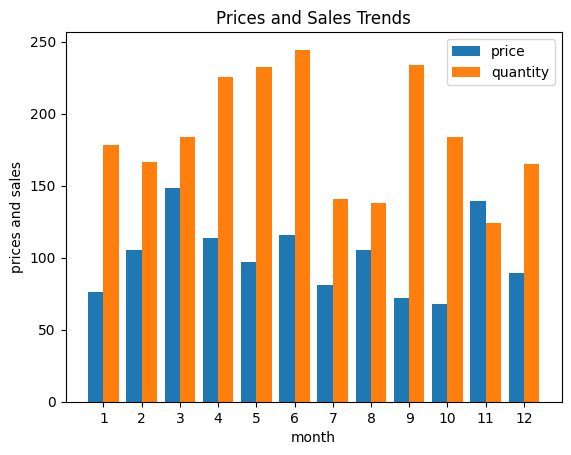

In [241]:
price_x = []
quantity_y = []
months = [f"{i}" for i in range(1,13)]
for month in range(1,13):
    inp = create_custom_input(year=2015, month=month, part_name='Struts')
    predicted_quantity = rf_model.predict(inp)
    x , y = predicted_quantity[0][0] , predicted_quantity[0][1]
    price_x.append(x)
    quantity_y.append(y)

X_axis = np.arange(len(price_x)) 

plt.bar(X_axis - 0.2, price_x, 0.4, label = 'price') 
plt.bar(X_axis + 0.2, quantity_y, 0.4, label = 'quantity') 
  
plt.xticks(X_axis, months)
plt.xlabel("month") 
plt.ylabel("prices and sales") 
plt.title("Prices and Sales Trends")
plt.legend()
plt.show()

# Model 2 ARIMA

In [308]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

In [313]:
sales_data['date'] = pd.to_datetime(sales_data[['year', 'month']].assign(day=1))

sales_data.set_index('date', inplace=True)
df = sales_data.sort_index()

part_data = df[df['part_name'] == 'Oil filters']

part_data_quantity = part_data['quantity_sold']
part_data_price = part_data['price_per_unit']
print(len(part_data_price),len(part_data_quantity))

60 60


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

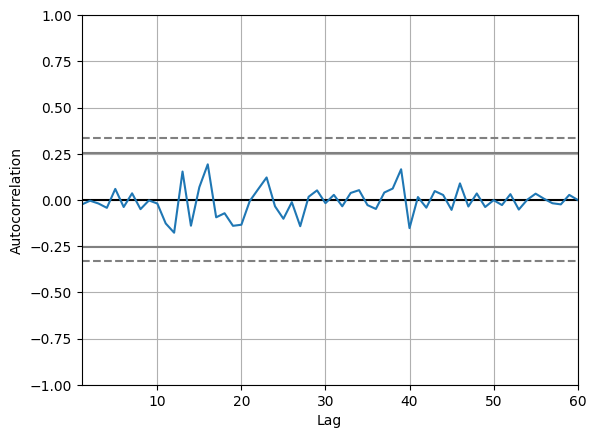

In [314]:
autocorrelation_plot(part_data_quantity)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

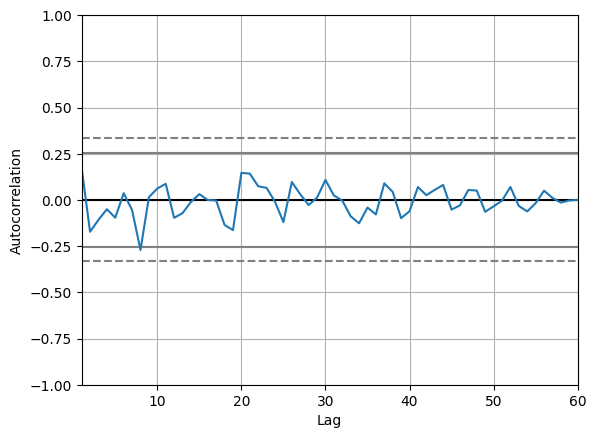

In [315]:
autocorrelation_plot(part_data_price)

In [310]:
price_model = pm.auto_arima(part_data_quantity, start_p=1, start_q=1,
                      max_p=5, max_q=5, seasonal=False,  
                      d=1, trace=True,
                      error_action='ignore', suppress_warnings=True,seasonal_test=True,
                      stepwise=True,n_fits=25
                      )
quantity_model = pm.auto_arima(part_data_price, start_p=1, start_q=1,
                      max_p=5, max_q=5, seasonal=False,  
                      d=1, trace=True,
                      error_action='ignore', suppress_warnings=True,seasonal_test=True,
                      stepwise=True,n_fits=25
                      )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=721.420, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=711.011, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=719.430, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=705.457, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=702.452, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=701.130, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=700.642, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=698.663, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=699.155, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best 

## Price Model

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\hp\AppData\Local\Programs

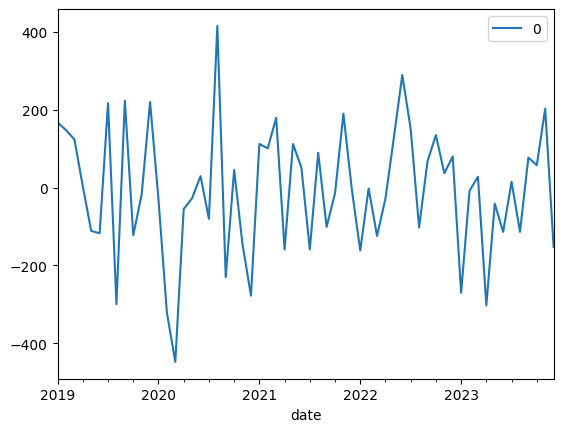

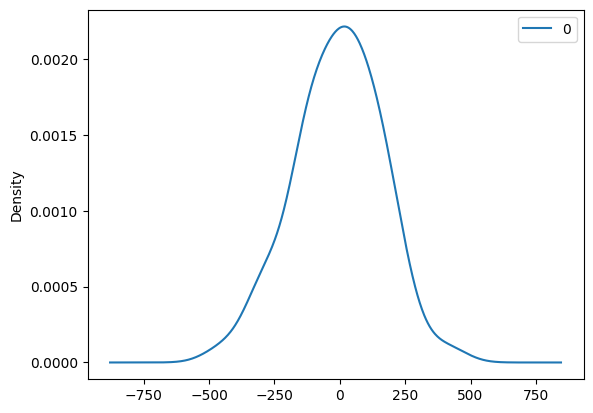

                0
count   60.000000
mean    -7.681438
std    165.987830
min   -447.741003
25%   -114.761900
50%     -3.831575
75%    111.564379
max    414.815417


In [317]:
price_model = ARIMA(part_data_quantity, order=(5,1,0),seasonal_order=(2, 1, 1, 12))
price_arima_result = price_model.fit()
residuals = pd.DataFrame(price_arima_result.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())


In [ ]:
quantity_model = ARIMA(part_data_price,order=(3,1,0),seasonal_order=(2, 1, 1, 12))
quantity_arima_result = quantity_model.fit()

In [304]:
forecast = price_arima_result.forecast(steps=24)

print("Forecasted prices for next 12 months:")
print(forecast)

Forecasted prices for next 12 months:
2024-01-01    180.057961
2024-02-01    143.751887
2024-03-01    244.567920
2024-04-01    209.463966
2024-05-01    159.418492
2024-06-01    166.416619
2024-07-01    110.305898
2024-08-01    182.005146
2024-09-01    222.114048
2024-10-01    206.891690
2024-11-01    101.441677
2024-12-01    162.461057
2025-01-01    222.364944
2025-02-01    186.985101
2025-03-01    192.193820
2025-04-01    198.279476
2025-05-01    191.695401
2025-06-01    149.981996
2025-07-01    130.596465
2025-08-01    227.857053
2025-09-01    182.538116
2025-10-01    208.525743
2025-11-01    141.162500
2025-12-01    150.996379
Freq: MS, Name: predicted_mean, dtype: float64


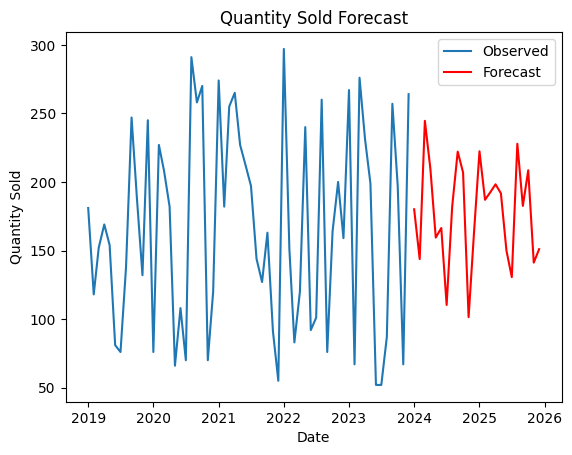

In [305]:
import matplotlib.pyplot as plt

# Plot original data
plt.plot(part_data_quantity, label='Observed')

# Plot the forecast
plt.plot(forecast, label='Forecast', color='red')
plt.title('Quantity Sold Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()
